Housekeeping

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.optimize import fsolve

from f_detrend import detrend_fuction

sn.set_style('whitegrid')
%matplotlib inline

In [2]:
# Expanded and modified version (first column now string)
def read_table(filename,keyword='ciclo',rescale=1,ncols=5,start=2,endword=None,index_to_int=True,debug=False):
    t0 = start
    t1 = ncols+start
    results_follow = 0
    row_names = []
    f = open(filename,'r')
    for line in f:
        words = line.split()
        if debug:
            print(words)
        if len(words)>1 and words[0] == keyword:
            results_follow=1
            if endword==None:
                colnames = words[t0:t1]
            else:
                buff_v = []
                for w in words[t0:]:
                    if w==endword:
                        break
                    else:
                        buff_v.append(w)
                colnames = buff_v[:-1]
                t1 = len(buff_v)+t0-1
            table_raw = np.empty(t1-t0)
        elif len(words)>1 and words[0] == "Total":
            break
        elif len(words)>1 and results_follow==1:
            row_names.append(words[0])
            buff_v = []
            for w in words[t0:t1]: 
                w = w.replace(",","")
                buff_v.append(w)
            table_raw = np.vstack((table_raw,np.array(buff_v,dtype=float)/rescale))
    table_raw = table_raw[1:,:]
    if debug:
        print(table_raw.shape)
        print(colnames)
    if index_to_int:
        return pd.DataFrame(table_raw, columns=colnames,index=np.array(row_names,dtype=int))
    else:
        return pd.DataFrame(table_raw, columns=colnames,index=np.array(row_names))

In [3]:
def normalise_table(table):
    cols = table.columns
    table['Total'] = table.sum(axis=1).copy()
    for col in cols:
        table[col] = table[col]/table['Total']
    return table   

In [4]:
dates = []
for year in range(1987,2023):
    for quarter in range(1,5):
        dates.append(str(year)+"Q"+str(quarter))
dates = dates[1:]

t0 = 59
t05 = 71
T = len(dates)
date_dict = dict(zip(range(t0,T+t0),dates))
date_dict_reverse = dict(zip(dates,range(0,T)))
date_dict_reverse_ciclo = dict(zip(dates,range(t0,T+t0)))

<a id='index'></a>


## Tenure assortativity for couples

Jump to
 - [Tenure Heatmaps](#heatwave)
 - [Employment plots](#emp)
 - [Age plots](#age)
 - [Hours plots](#hours)
  
 --------------
 
 ### Want to switch jobs

In [18]:
path = './results/'

stocks = normalise_table(read_table(path+'stocks.log',keyword='ciclo',rescale=1,ncols=6))
stocks_w = normalise_table(read_table(path+'stocks_w.log',keyword='ciclo',rescale=100,ncols=6))
stocks_pt = normalise_table(read_table(path+'stocks_pt.log',keyword='ciclo',rescale=1,ncols=7))
stocks_pt_w = normalise_table(read_table(path+'stocks_pt_w.log',keyword='ciclo',rescale=100,ncols=7))
stocks.head()

A         D         I         P         T         U     Total
130  0.082918  0.004410  0.550953  0.216517  0.098899  0.046302  155997.0
131  0.080478  0.004733  0.549293  0.218468  0.103884  0.043144  154018.0
132  0.080035  0.004302  0.548455  0.219763  0.108301  0.039144  149934.0
133  0.080271  0.004387  0.547885  0.221097  0.105532  0.040828  150902.0
134  0.080691  0.004049  0.547443  0.222194  0.103719  0.041904  155333.0

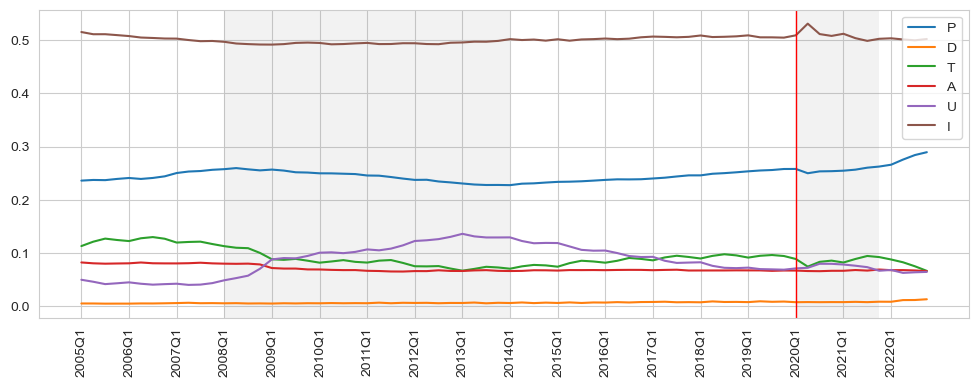

In [19]:
t00 = 59
t0 = int(stocks_w["P"].index[0])-t00

plt.figure(figsize=(12,4))
# plt.suptitle('Porcentaje de trabajadores con contrato fijo que están buscando otro empleo', fontsize=14, y=1.05)
# plt.subplot(121)
# plt.title('Mujeres',fontsize=14,y=1.025)
for state in ['P', 'D', 'T', 'A','U','I']:
    plt.plot(dates[t0:],stocks_w[state],label=state)

plt.axvline('2020Q1',c='r',lw=1)
# plt.ylim(0,0.12)
plt.xticks(dates[t0::4],rotation=90)
plt.axvspan('2008Q1', '2014Q1', color='grey', alpha=0.1, lw=0)
plt.axvspan('2020Q1', '2021Q4', color='grey', alpha=0.1, lw=0)
plt.legend()


plt.show()

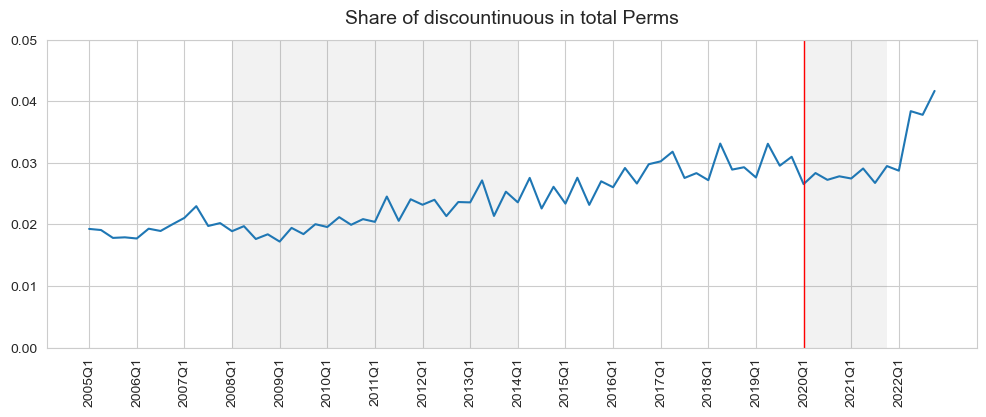

In [20]:
t00 = 59
t0 = int(stocks_w["P"].index[0])-t00

plt.figure(figsize=(12,4))
# plt.suptitle('Porcentaje de trabajadores con contrato fijo que están buscando otro empleo', fontsize=14, y=1.05)
# plt.subplot(121)
plt.title('Share of discountinuous in total Perms',fontsize=14,y=1.025)
plt.plot(dates[t0:],stocks_w['D']/(stocks_w['P']+stocks_w['D']))

plt.axvline('2020Q1',c='r',lw=1)
plt.ylim(0,0.05)
plt.xticks(dates[t0::4],rotation=90)
plt.axvspan('2008Q1', '2014Q1', color='grey', alpha=0.1, lw=0)
plt.axvspan('2020Q1', '2021Q4', color='grey', alpha=0.1, lw=0)
# plt.legend()


plt.show()

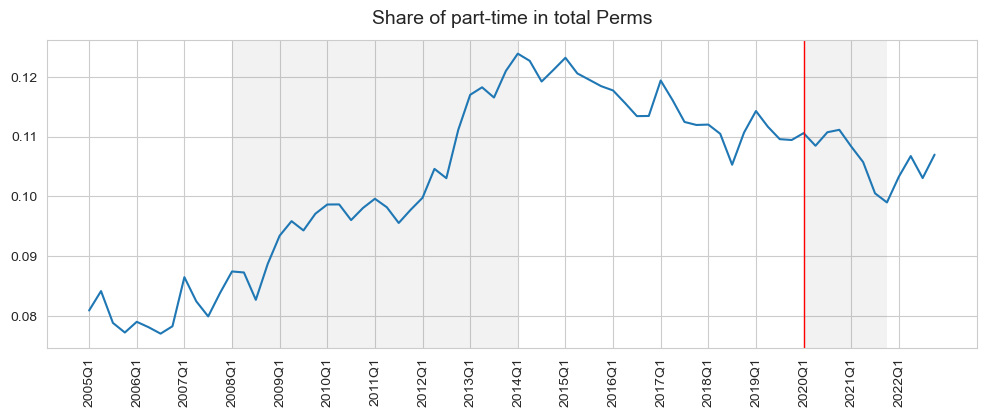

In [22]:
t00 = 59
t0 = int(stocks_w["P"].index[0])-t00

plt.figure(figsize=(12,4))
# plt.suptitle('Porcentaje de trabajadores con contrato fijo que están buscando otro empleo', fontsize=14, y=1.05)
# plt.subplot(121)
plt.title('Share of part-time in total Perms',fontsize=14,y=1.025)
plt.plot(dates[t0:],stocks_pt_w['H']/(stocks_pt_w['P']+stocks_pt_w['D']+stocks_pt_w['H']))

plt.axvline('2020Q1',c='r',lw=1)
# plt.ylim(0.15,0.25)
plt.xticks(dates[t0::4],rotation=90)
plt.axvspan('2008Q1', '2014Q1', color='grey', alpha=0.1, lw=0)
plt.axvspan('2020Q1', '2021Q4', color='grey', alpha=0.1, lw=0)
# plt.legend()


plt.show()

[]

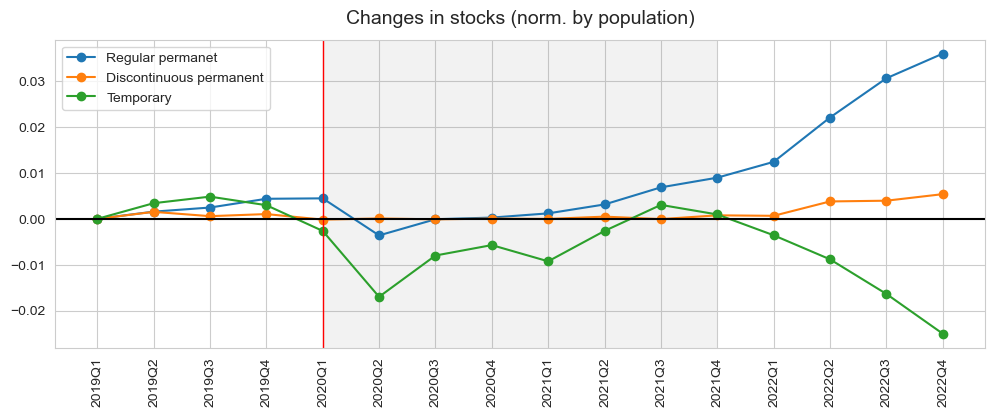

In [52]:
t00 = date_dict_reverse['2019Q1']
t0 = date_dict_reverse_ciclo['2019Q1']

plt.figure(figsize=(12,4))
# plt.suptitle('Porcentaje de trabajadores con contrato fijo que están buscando otro empleo', fontsize=14, y=1.05)
# plt.subplot(121)
plt.title('Changes in stocks (norm. by population)',fontsize=14,y=1.025)
plt.plot(dates[t00:],(stocks_w['P']-stocks_w['P'].loc[t0]).loc[t0:],marker='o',label='Regular permanet')
plt.plot(dates[t00:],(stocks_w['D']-stocks_w['D'].loc[t0]).loc[t0:],marker='o',label='Discontinuous permanent')
plt.plot(dates[t00:],(stocks_w['T']-stocks_w['T'].loc[t0]).loc[t0:],marker='o',label='Temporary')

plt.axvline('2020Q1',c='r',lw=1)
# plt.ylim(0.15,0.25)
plt.axhline(c='k')
plt.xticks(dates[t00::],rotation=90)
# plt.axvspan('2008Q1', '2014Q1', color='grey', alpha=0.1, lw=0)
plt.axvspan('2020Q1', '2021Q4', color='grey', alpha=0.1, lw=0)
plt.legend()


plt.show()

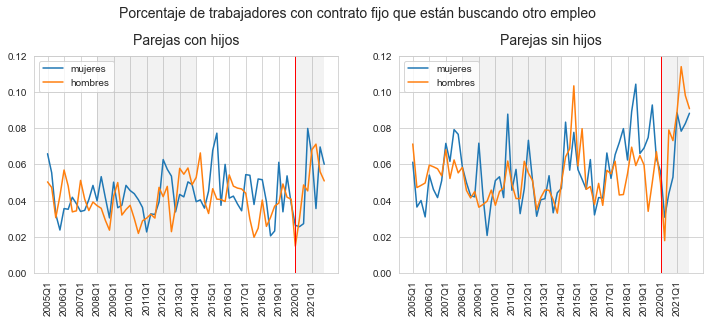

In [133]:
t00 = 59
t0 = int(search_mo['1'].index[0])-t00

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.suptitle('Porcentaje de trabajadores con contrato fijo que están buscando otro empleo', fontsize=14, y=1.05)
plt.title('Parejas con hijos',fontsize=14,y=1.025)
plt.plot(dates[t0:],search_mo["1"],label='mujeres')
plt.plot(dates[t0:],search_fa["1"],label='hombres')
plt.axvline('2020Q1',c='r',lw=1)
plt.ylim(0,0.12)
plt.xticks(dates[t0::4],rotation=90)
plt.axvspan('2008Q1', '2014Q1', color='grey', alpha=0.1, lw=0)
plt.axvspan('2020Q1', '2021Q4', color='grey', alpha=0.1, lw=0)
plt.legend()

plt.subplot(122)
plt.title('Parejas sin hijos',fontsize=14,y=1.025)
plt.plot(dates[t0:],search_wo["1"],label='mujeres')
plt.plot(dates[t0:],search_me["1"],label='hombres')
plt.axvline('2020Q1',c='r',lw=1)
plt.ylim(0,0.12)
plt.xticks(dates[t0::4],rotation=90)
plt.axvspan('2008Q1', '2014Q1', color='grey', alpha=0.1, lw=0)
plt.axvspan('2020Q1', '2021Q4', color='grey', alpha=0.1, lw=0)
plt.legend()

plt.show()

In [48]:
path = './rawtabs/'

pt_mo = normalise_table(read_table(path+'gopart_mothers.log',keyword='ciclo',rescale=100,ncols=2))
pt_wo = normalise_table(read_table(path+'gopart_mothers_0k.log',keyword='ciclo',rescale=100,ncols=2))
pt_fa = normalise_table(read_table(path+'gopart_fathers.log',keyword='ciclo',rescale=100,ncols=2))
pt_me = normalise_table(read_table(path+'gopart_fathers_0k.log',keyword='ciclo',rescale=100,ncols=2))
pt_mo.head()

1         6      Total
130  0.697929  0.302071  245909.83
131  0.695805  0.304195  244635.01
132  0.701695  0.298305  263640.05
133  0.697837  0.302163  264102.05
134  0.705670  0.294330  264789.88

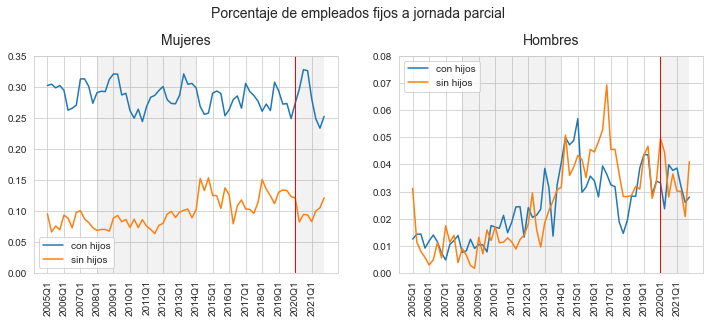

In [134]:
t00 = 59
t0 = int(pt_mo['1'].index[0])-t00

plt.figure(figsize=(12,4))
plt.suptitle('Porcentaje de empleados fijos a jornada parcial',fontsize=14,y=1.05)
plt.subplot(121)
plt.title('Mujeres',fontsize=14,y=1.025)
plt.plot(dates[t0:],pt_mo["6"],label='con hijos')
plt.plot(dates[t0:],pt_wo["6"],label='sin hijos')
plt.axvline('2020Q1',c='r',lw=1)
plt.ylim(0,0.35)
plt.xticks(dates[t0::4],rotation=90)
plt.axvspan('2008Q1', '2014Q1', color='grey', alpha=0.1, lw=0)
plt.axvspan('2020Q1', '2021Q4', color='grey', alpha=0.1, lw=0)
plt.legend()

plt.subplot(122)
plt.title('Hombres',fontsize=14,y=1.025)
plt.plot(dates[t0:],pt_fa["6"],label='con hijos')
plt.plot(dates[t0:],pt_me["6"],label='sin hijos')
plt.axvline('2020Q1',c='r',lw=1)
plt.ylim(0,0.08)
plt.xticks(dates[t0::4],rotation=90)
plt.axvspan('2008Q1', '2014Q1', color='grey', alpha=0.1, lw=0)
plt.axvspan('2020Q1', '2021Q4', color='grey', alpha=0.1, lw=0)
plt.legend()

plt.show()

In [58]:
path = './rawtabs/'

stocks_mo = normalise_table(read_table(path+'goaut_mothers.log',keyword='ciclo',rescale=100,ncols=5))
stocks_wo = normalise_table(read_table(path+'goaut_mothers_0k.log',keyword='ciclo',rescale=100,ncols=5))
stocks_fa = normalise_table(read_table(path+'goaut_fathers.log',keyword='ciclo',rescale=100,ncols=5))
stocks_me = normalise_table(read_table(path+'goaut_fathers_0k.log',keyword='ciclo',rescale=100,ncols=5))
stocks_mo.head()

A         I         P         T         U      Total
130  0.076693  0.374655  0.303951  0.150362  0.094338  809044.18
131  0.088195  0.349570  0.308066  0.173177  0.080991  794098.40
132  0.073718  0.359757  0.325347  0.175223  0.065955  810334.62
133  0.074409  0.353661  0.321428  0.178463  0.072040  821653.52
134  0.070685  0.331097  0.314580  0.198486  0.085151  841724.96

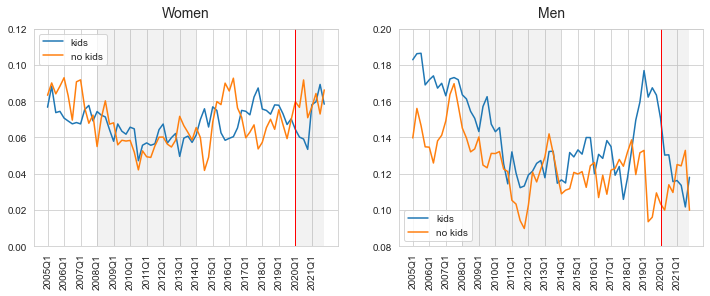

In [65]:
t00 = 59
t0 = int(stocks_mo['A'].index[0])-t00

plt.figure(figsize=(12,4))
# plt.suptitle('Share of Part-time',fontsize=14,y=1.05)
plt.subplot(121)
plt.title('Women',fontsize=14,y=1.025)
plt.plot(dates[t0:],stocks_mo["A"],label='kids')
plt.plot(dates[t0:],stocks_wo["A"],label='no kids')
plt.axvline('2020Q1',c='r',lw=1)
plt.ylim(0,0.12)
plt.xticks(dates[t0::4],rotation=90)
plt.axvspan('2008Q1', '2014Q1', color='grey', alpha=0.1, lw=0)
plt.axvspan('2020Q1', '2021Q4', color='grey', alpha=0.1, lw=0)
plt.legend()

plt.subplot(122)
plt.title('Men',fontsize=14,y=1.025)
plt.plot(dates[t0:],stocks_fa["A"],label='kids')
plt.plot(dates[t0:],stocks_me["A"],label='no kids')
plt.axvline('2020Q1',c='r',lw=1)
plt.ylim(0.08,0.2)
plt.xticks(dates[t0::4],rotation=90)
plt.axvspan('2008Q1', '2014Q1', color='grey', alpha=0.1, lw=0)
plt.axvspan('2020Q1', '2021Q4', color='grey', alpha=0.1, lw=0)
plt.legend()

plt.show()

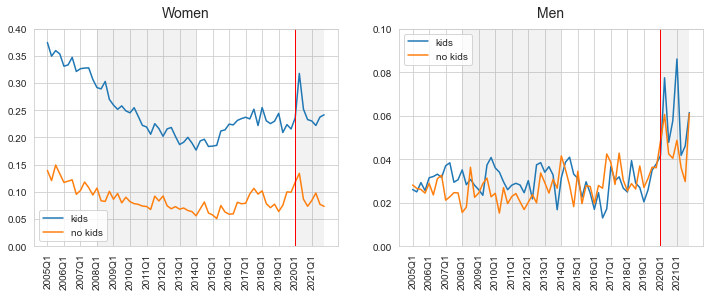

In [66]:
t00 = 59
t0 = int(stocks_mo['A'].index[0])-t00

plt.figure(figsize=(12,4))
# plt.suptitle('Share of Part-time',fontsize=14,y=1.05)
plt.subplot(121)
plt.title('Women',fontsize=14,y=1.025)
plt.plot(dates[t0:],stocks_mo["I"],label='kids')
plt.plot(dates[t0:],stocks_wo["I"],label='no kids')
plt.axvline('2020Q1',c='r',lw=1)
plt.ylim(0,0.4)
plt.xticks(dates[t0::4],rotation=90)
plt.axvspan('2008Q1', '2014Q1', color='grey', alpha=0.1, lw=0)
plt.axvspan('2020Q1', '2021Q4', color='grey', alpha=0.1, lw=0)
plt.legend()

plt.subplot(122)
plt.title('Men',fontsize=14,y=1.025)
plt.plot(dates[t0:],stocks_fa["I"],label='kids')
plt.plot(dates[t0:],stocks_me["I"],label='no kids')
plt.axvline('2020Q1',c='r',lw=1)
plt.ylim(0,0.1)
plt.xticks(dates[t0::4],rotation=90)
plt.axvspan('2008Q1', '2014Q1', color='grey', alpha=0.1, lw=0)
plt.axvspan('2020Q1', '2021Q4', color='grey', alpha=0.1, lw=0)
plt.legend()

plt.show()

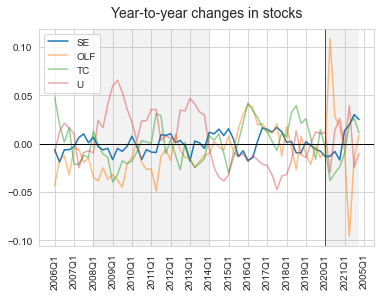

In [101]:
plt.figure(figsize=(6,4))
plt.title('Year-to-year changes in stocks',fontsize=14,y=1.025)
plt.plot(dates[t0+4:],stocks_mo["A"][4:].values-stocks_mo["A"][:-4].values,label='SE')
plt.plot(dates[t0+4:],stocks_mo["I"][4:].values-stocks_mo["I"][:-4].values,label='OLF',alpha=0.5)
plt.plot(dates[t0+4:],stocks_mo["T"][4:].values-stocks_mo["T"][:-4].values,label='TC',alpha=0.5)
plt.plot(dates[t0+4:],stocks_mo["U"][4:].values-stocks_mo["U"][:-4].values,label='U',alpha=0.4)
plt.xticks(dates[t0::4],rotation=90)
plt.axhline(lw=1,c="k")
plt.axvspan('2008Q1', '2014Q1', color='grey', alpha=0.1, lw=0)
plt.axvspan('2020Q1', '2021Q4', color='grey', alpha=0.1, lw=0)
plt.axvline('2020Q1',c='r',lw=1)
plt.legend()
plt.show()

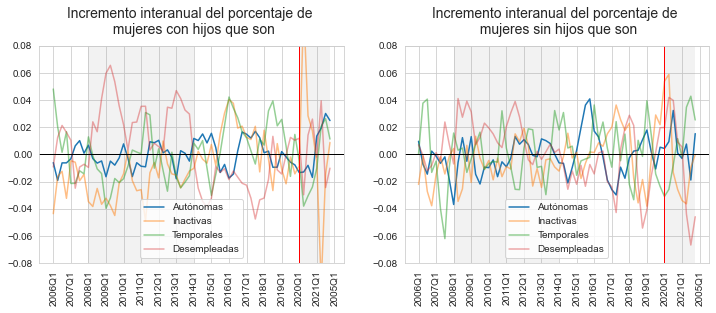

In [140]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.title('Incremento interanual del porcentaje de \n mujeres con hijos que son',fontsize=14,y=1.025)
plt.plot(dates[t0+4:],stocks_mo["A"][4:].values-stocks_mo["A"][:-4].values,label='Autónomas')
plt.plot(dates[t0+4:],stocks_mo["I"][4:].values-stocks_mo["I"][:-4].values,label='Inactivas',alpha=0.5)
plt.plot(dates[t0+4:],stocks_mo["T"][4:].values-stocks_mo["T"][:-4].values,label='Temporales',alpha=0.5)
plt.plot(dates[t0+4:],stocks_mo["U"][4:].values-stocks_mo["U"][:-4].values,label='Desempleadas',alpha=0.4)
plt.xticks(dates[t0::4],rotation=90)
plt.axhline(lw=1,c="k")
plt.ylim(-0.08,0.08)
plt.axvspan('2008Q1', '2014Q1', color='grey', alpha=0.1, lw=0)
plt.axvspan('2020Q1', '2021Q4', color='grey', alpha=0.1, lw=0)
plt.axvline('2020Q1',c='r',lw=1)
plt.legend()

plt.subplot(122)
plt.title('Incremento interanual del porcentaje de \n mujeres sin hijos que son',fontsize=14,y=1.025)
plt.plot(dates[t0+4:],stocks_wo["A"][4:].values-stocks_wo["A"][:-4].values,label='Autónomas')
plt.plot(dates[t0+4:],stocks_wo["I"][4:].values-stocks_wo["I"][:-4].values,label='Inactivas',alpha=0.5)
plt.plot(dates[t0+4:],stocks_wo["T"][4:].values-stocks_wo["T"][:-4].values,label='Temporales',alpha=0.5)
plt.plot(dates[t0+4:],stocks_wo["U"][4:].values-stocks_wo["U"][:-4].values,label='Desempleadas',alpha=0.4)
plt.xticks(dates[t0::4],rotation=90)
plt.axhline(lw=1,c="k")
plt.ylim(-0.08,0.08)
plt.axvspan('2008Q1', '2014Q1', color='grey', alpha=0.1, lw=0)
plt.axvspan('2020Q1', '2021Q4', color='grey', alpha=0.1, lw=0)
plt.axvline('2020Q1',c='r',lw=1)
plt.legend()
plt.show()

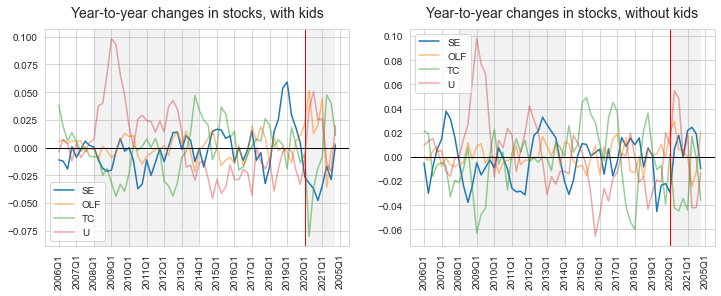

In [106]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.title('Year-to-year changes in stocks, with kids',fontsize=14,y=1.025)
plt.plot(dates[t0+4:],stocks_fa["A"][4:].values-stocks_fa["A"][:-4].values,label='SE')
plt.plot(dates[t0+4:],stocks_fa["I"][4:].values-stocks_fa["I"][:-4].values,label='OLF',alpha=0.5)
plt.plot(dates[t0+4:],stocks_fa["T"][4:].values-stocks_fa["T"][:-4].values,label='TC',alpha=0.5)
plt.plot(dates[t0+4:],stocks_fa["U"][4:].values-stocks_fa["U"][:-4].values,label='U',alpha=0.4)
plt.xticks(dates[t0::4],rotation=90)
plt.axhline(lw=1,c="k")
plt.axvspan('2008Q1', '2014Q1', color='grey', alpha=0.1, lw=0)
plt.axvspan('2020Q1', '2021Q4', color='grey', alpha=0.1, lw=0)
plt.axvline('2020Q1',c='r',lw=1)
plt.legend()

plt.subplot(122)
plt.title('Year-to-year changes in stocks, without kids',fontsize=14,y=1.025)
plt.plot(dates[t0+4:],stocks_me["A"][4:].values-stocks_me["A"][:-4].values,label='SE')
plt.plot(dates[t0+4:],stocks_me["I"][4:].values-stocks_me["I"][:-4].values,label='OLF',alpha=0.5)
plt.plot(dates[t0+4:],stocks_me["T"][4:].values-stocks_me["T"][:-4].values,label='TC',alpha=0.5)
plt.plot(dates[t0+4:],stocks_me["U"][4:].values-stocks_me["U"][:-4].values,label='U',alpha=0.4)
plt.xticks(dates[t0::4],rotation=90)
plt.axhline(lw=1,c="k")
plt.axvspan('2008Q1', '2014Q1', color='grey', alpha=0.1, lw=0)
plt.axvspan('2020Q1', '2021Q4', color='grey', alpha=0.1, lw=0)
plt.axvline('2020Q1',c='r',lw=1)
plt.legend()
plt.show()

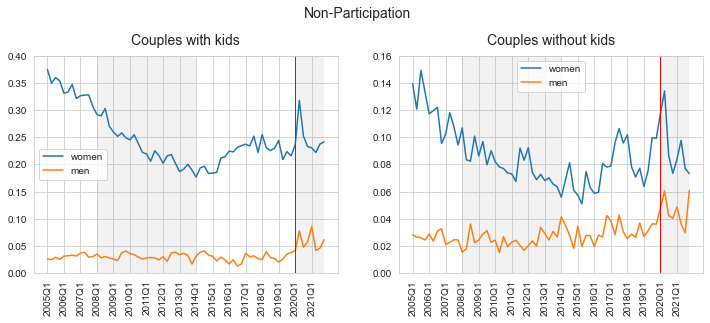

In [70]:
t00 = 59
t0 = int(stocks_mo['A'].index[0])-t00

plt.figure(figsize=(12,4))
plt.suptitle('Non-Participation',fontsize=14,y=1.05)
plt.subplot(121)
plt.title('Couples with kids',fontsize=14,y=1.025)
plt.plot(dates[t0:],stocks_mo["I"],label='women')
plt.plot(dates[t0:],stocks_fa["I"],label='men')
plt.axvline('2020Q1',c='r',lw=1)
plt.ylim(0,0.4)
plt.xticks(dates[t0::4],rotation=90)
plt.axvspan('2008Q1', '2014Q1', color='grey', alpha=0.1, lw=0)
plt.axvspan('2020Q1', '2021Q4', color='grey', alpha=0.1, lw=0)
plt.legend()

plt.subplot(122)
plt.title('Couples without kids',fontsize=14,y=1.025)
plt.plot(dates[t0:],stocks_wo["I"],label='women')
plt.plot(dates[t0:],stocks_me["I"],label='men')
plt.axvline('2020Q1',c='r',lw=1)
plt.ylim(0,0.16)
plt.xticks(dates[t0::4],rotation=90)
plt.axvspan('2008Q1', '2014Q1', color='grey', alpha=0.1, lw=0)
plt.axvspan('2020Q1', '2021Q4', color='grey', alpha=0.1, lw=0)
plt.legend()

plt.show()

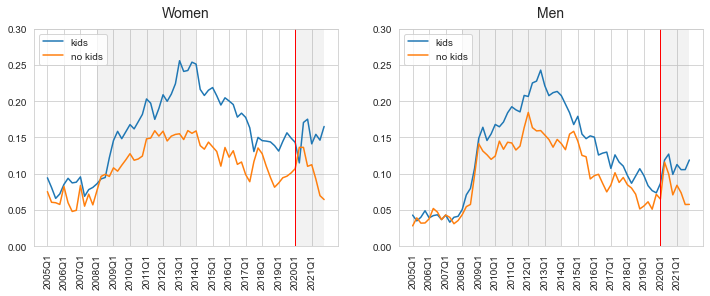

In [64]:
t00 = 59
t0 = int(stocks_mo['A'].index[0])-t00

plt.figure(figsize=(12,4))
# plt.suptitle('Share of Part-time',fontsize=14,y=1.05)
plt.subplot(121)
plt.title('Women',fontsize=14,y=1.025)
plt.plot(dates[t0:],stocks_mo["U"],label='kids')
plt.plot(dates[t0:],stocks_wo["U"],label='no kids')
plt.axvline('2020Q1',c='r',lw=1)
plt.ylim(0,0.3)
plt.xticks(dates[t0::4],rotation=90)
plt.axvspan('2008Q1', '2014Q1', color='grey', alpha=0.1, lw=0)
plt.axvspan('2020Q1', '2021Q4', color='grey', alpha=0.1, lw=0)
plt.legend()

plt.subplot(122)
plt.title('Men',fontsize=14,y=1.025)
plt.plot(dates[t0:],stocks_fa["U"],label='kids')
plt.plot(dates[t0:],stocks_me["U"],label='no kids')
plt.axvline('2020Q1',c='r',lw=1)
plt.ylim(0,0.3)
plt.xticks(dates[t0::4],rotation=90)
plt.axvspan('2008Q1', '2014Q1', color='grey', alpha=0.1, lw=0)
plt.axvspan('2020Q1', '2021Q4', color='grey', alpha=0.1, lw=0)
plt.legend()

plt.show()

<a id='hours'></a>


## Work less hours

Jump to
 - [Index](#index)
 - [switch jobs](#switch)
 - [go part-time](#part-time)
 - [go self-employed/inactive](#stocks)

In [121]:
path = './rawtabs/'
date_cuts_t = ['2005Q1','2008Q1','2013Q1','2016Q1','2020Q1']
date_cuts_t1 = ['2007Q4','2012Q4','2015Q4','2019Q4','2021Q4']
date_cuts = np.vstack((date_cuts_t,date_cuts_t1))

hours_mo = read_table(path+'hours_mothers.log',keyword='ciclo',rescale=1,ncols=2)
hours_mo['dates'] = hours_mo.index.map(date_dict)
hours_wo = read_table(path+'hours_mothers_0k.log',keyword='ciclo',rescale=1,ncols=2)
hours_wo['dates'] = hours_wo.index.map(date_dict)
hours_fa = read_table(path+'hours_fathers.log',keyword='ciclo',rescale=1,ncols=2)
hours_fa['dates'] = hours_fa.index.map(date_dict)
hours_me = read_table(path+'hours_fathers_0k.log',keyword='ciclo',rescale=1,ncols=2)
hours_me['dates'] = hours_me.index.map(date_dict)

hours_mo_trend,hours_mo_predict = detrend_fuction(hours_mo,'Mean',date_cuts,
                           date0='2021Q4',dateT='2021Q4',date_dict=date_dict_reverse_ciclo)
hours_mo_ds = hours_mo_trend + hours_mo['Mean'] - hours_mo_predict

hours_fa_trend,hours_fa_predict = detrend_fuction(hours_fa,'Mean',date_cuts,
                           date0='2021Q4',dateT='2021Q4',date_dict=date_dict_reverse_ciclo)
hours_fa_ds = hours_fa_trend + hours_fa['Mean'] - hours_fa_predict

hours_wo_trend,hours_wo_predict = detrend_fuction(hours_wo,'Mean',date_cuts,
                           date0='2021Q4',dateT='2021Q4',date_dict=date_dict_reverse_ciclo)
hours_wo_ds = hours_wo_trend + hours_wo['Mean'] - hours_wo_predict

hours_me_trend,hours_me_predict = detrend_fuction(hours_me,'Mean',date_cuts,
                           date0='2021Q4',dateT='2021Q4',date_dict=date_dict_reverse_ciclo)
hours_me_ds = hours_me_trend + hours_me['Mean'] - hours_me_predict


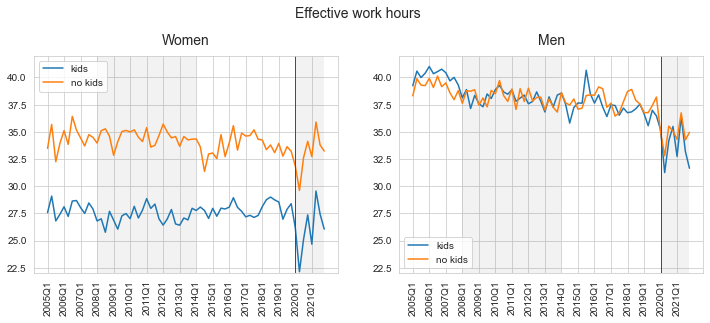

In [125]:
t00 = 59
t0 = int(hours_mo['Mean'].index[0])-t00

plt.figure(figsize=(12,4))
plt.suptitle('Effective work hours',fontsize=14,y=1.05)
plt.subplot(121)
plt.title('Women',fontsize=14,y=1.025)
plt.plot(dates[t0:],hours_mo_ds,label='kids')
plt.plot(dates[t0:],hours_wo_ds,label='no kids')
plt.axvline('2020Q1',c='r',lw=1)
plt.ylim(22,42)
plt.xticks(dates[t0::4],rotation=90)
plt.axvspan('2008Q1', '2014Q1', color='grey', alpha=0.1, lw=0)
plt.axvspan('2020Q1', '2021Q4', color='grey', alpha=0.1, lw=0)
plt.legend()

plt.subplot(122)
plt.title('Men',fontsize=14,y=1.025)
plt.plot(dates[t0:],hours_fa_ds,label='kids')
plt.plot(dates[t0:],hours_me_ds,label='no kids')
plt.axvline('2020Q1',c='r',lw=1)
plt.ylim(22,42)
plt.xticks(dates[t0::4],rotation=90)
plt.axvspan('2008Q1', '2014Q1', color='grey', alpha=0.1, lw=0)
plt.axvspan('2020Q1', '2021Q4', color='grey', alpha=0.1, lw=0)
plt.legend()

plt.show()

Full-time only

In [141]:
path = './rawtabs/'
date_cuts_t = ['2005Q1','2008Q1','2013Q1','2016Q1','2020Q1']
date_cuts_t1 = ['2007Q4','2012Q4','2015Q4','2019Q4','2021Q4']
date_cuts = np.vstack((date_cuts_t,date_cuts_t1))

hours_mo = read_table(path+'hours_mothers_ft.log',keyword='ciclo',rescale=1,ncols=2)
hours_mo['dates'] = hours_mo.index.map(date_dict)
hours_wo = read_table(path+'hours_mothers_0k_ft.log',keyword='ciclo',rescale=1,ncols=2)
hours_wo['dates'] = hours_wo.index.map(date_dict)
hours_fa = read_table(path+'hours_fathers_ft.log',keyword='ciclo',rescale=1,ncols=2)
hours_fa['dates'] = hours_fa.index.map(date_dict)
hours_me = read_table(path+'hours_fathers_0k_ft.log',keyword='ciclo',rescale=1,ncols=2)
hours_me['dates'] = hours_me.index.map(date_dict)

hours_mo_trend,hours_mo_predict = detrend_fuction(hours_mo,'Mean',date_cuts,
                           date0='2021Q4',dateT='2021Q4',date_dict=date_dict_reverse_ciclo)
hours_mo_ds_ft = hours_mo_trend + hours_mo['Mean'] - hours_mo_predict

hours_fa_trend,hours_fa_predict = detrend_fuction(hours_fa,'Mean',date_cuts,
                           date0='2021Q4',dateT='2021Q4',date_dict=date_dict_reverse_ciclo)
hours_fa_ds_ft = hours_fa_trend + hours_fa['Mean'] - hours_fa_predict

hours_wo_trend,hours_wo_predict = detrend_fuction(hours_wo,'Mean',date_cuts,
                           date0='2021Q4',dateT='2021Q4',date_dict=date_dict_reverse_ciclo)
hours_wo_ds_ft = hours_wo_trend + hours_wo['Mean'] - hours_wo_predict

hours_me_trend,hours_me_predict = detrend_fuction(hours_me,'Mean',date_cuts,
                           date0='2021Q4',dateT='2021Q4',date_dict=date_dict_reverse_ciclo)
hours_me_ds_ft = hours_me_trend + hours_me['Mean'] - hours_me_predict


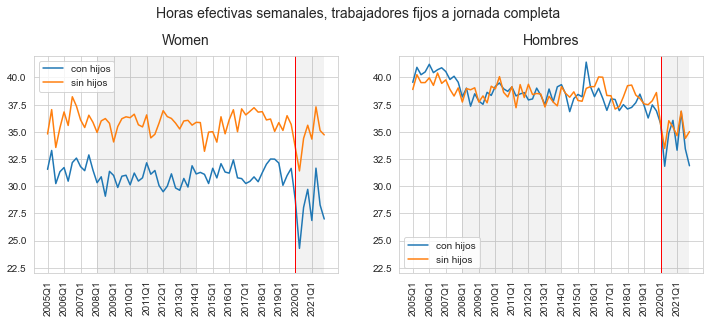

In [145]:
t00 = 59
t0 = int(hours_mo['Mean'].index[0])-t00

plt.figure(figsize=(12,4))
plt.suptitle("Horas efectivas semanales, trabajadores fijos a jornada completa", fontsize=14, y=1.05)
plt.subplot(121)
plt.title('Women',fontsize=14,y=1.025)
plt.plot(dates[t0:],hours_mo_ds_ft,label='con hijos')
plt.plot(dates[t0:],hours_wo_ds_ft,label='sin hijos')
plt.axvline('2020Q1',c='r',lw=1)
plt.ylim(22,42)
plt.xticks(dates[t0::4],rotation=90)
plt.axvspan('2008Q1', '2014Q1', color='grey', alpha=0.1, lw=0)
plt.axvspan('2020Q1', '2021Q4', color='grey', alpha=0.1, lw=0)
plt.legend()

plt.subplot(122)
plt.title('Hombres',fontsize=14,y=1.025)
plt.plot(dates[t0:],hours_fa_ds_ft,label='con hijos')
plt.plot(dates[t0:],hours_me_ds_ft,label='sin hijos')
plt.axvline('2020Q1',c='r',lw=1)
plt.ylim(22,42)
plt.xticks(dates[t0::4],rotation=90)
plt.axvspan('2008Q1', '2014Q1', color='grey', alpha=0.1, lw=0)
plt.axvspan('2020Q1', '2021Q4', color='grey', alpha=0.1, lw=0)
plt.legend()

plt.show()

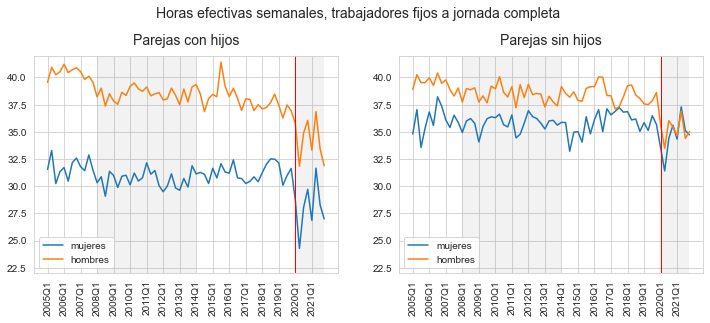

In [146]:
t00 = 59
t0 = int(hours_mo['Mean'].index[0])-t00

plt.figure(figsize=(12,4))
plt.suptitle("Horas efectivas semanales, trabajadores fijos a jornada completa", fontsize=14, y=1.05)
plt.subplot(121)
plt.title('Parejas con hijos',fontsize=14,y=1.025)
plt.plot(dates[t0:],hours_mo_ds_ft,label='mujeres')
plt.plot(dates[t0:],hours_fa_ds_ft,label='hombres')
plt.axvline('2020Q1',c='r',lw=1)
plt.ylim(22,42)
plt.xticks(dates[t0::4],rotation=90)
plt.axvspan('2008Q1', '2014Q1', color='grey', alpha=0.1, lw=0)
plt.axvspan('2020Q1', '2021Q4', color='grey', alpha=0.1, lw=0)
plt.legend()

plt.subplot(122)
plt.title('Parejas sin hijos',fontsize=14,y=1.025)
plt.plot(dates[t0:],hours_wo_ds_ft,label='mujeres')
plt.plot(dates[t0:],hours_me_ds_ft,label='hombres')
plt.axvline('2020Q1',c='r',lw=1)
plt.ylim(22,42)
plt.xticks(dates[t0::4],rotation=90)
plt.axvspan('2008Q1', '2014Q1', color='grey', alpha=0.1, lw=0)
plt.axvspan('2020Q1', '2021Q4', color='grey', alpha=0.1, lw=0)
plt.legend()

plt.show()

<a id='export'></a>


## Export cell

Please excecute the other sections first

Jump to
 - [Index](#index)
 - [Tenure Heatmaps](#heatwave)
 - [Employment plots](#emp)
 - [Age plots](#age)
 - [Hours plots](#hours)

In [47]:
tenure_mom = ten_w_mo['Mean'].copy()
tenure_mom.rename('Tenure_mother',inplace=True)
tenure_dad = ten_w_fa['Mean'].copy()
tenure_dad.rename('Tenure_father',inplace=True)
tenure_mom_p = ten_w_mo_p['Mean'].copy()
tenure_mom_p.rename('Tenure_mother_PC',inplace=True)
tenure_dad_p = ten_w_fa_p['Mean'].copy()
tenure_dad_p.rename('Tenure_father_PC',inplace=True)

emp_mom = emp_tab_mum['P']+emp_tab_mum['T']
emp_mom.rename('Employment_mother',inplace=True)
emp_dad = emp_tab_dad['P']+emp_tab_dad['T']
emp_dad.rename('Employment_father',inplace=True)

par_mom = 1-emp_tab_mum['I']
par_mom.rename('Participation_mother',inplace=True)
par_dad = 1-emp_tab_dad['I']
par_dad.rename('Participation_father',inplace=True)

unemp_mom = emp_tab_mum['U']/(1-emp_tab_mum['I'])
unemp_mom.rename('Unemployment_mother',inplace=True)
unemp_dad = emp_tab_dad['U']/(1-emp_tab_dad['I'])
unemp_dad.rename('Unemployment_father',inplace=True)

age_mom = age_tab_mum['Mean'].copy()
age_mom.rename('Age_mother',inplace=True)
age_dad = age_tab_dad['Mean'].copy()
age_dad.rename('Age_father',inplace=True)

hours_mums_deseason.rename('Hours_mother',inplace=True)
hours_dads_deseason.rename('Hours_father',inplace=True)

quarters = pd.Series(dict(zip(hours_mums_deseason.index,dates[date_dict_reverse['2005Q1']:])),name='dates')

df_export = pd.concat((tenure_mom,tenure_dad,tenure_mom_p,tenure_dad_p,par_mom,par_dad,emp_mom,emp_dad,unemp_mom,unemp_dad,
                       age_mom,age_dad,hours_mums_deseason,hours_dads_deseason,quarters),axis=1)
df_export.head()

Tenure_mother  Tenure_father  Tenure_mother_PC  Tenure_father_PC  \
130       91.09012       116.9287          127.9036          141.4162   
131       89.06780       115.4223          126.7102          143.1194   
132       89.37599       114.5817          125.6732          140.4082   
133       90.05831       114.4557          129.0288          141.2429   
134       91.16219       116.4211          130.2905          146.4587   

     Participation_mother  Participation_father  Employment_mother  \
130              0.633599              0.961774           0.450439   
131              0.635941              0.963031           0.462568   
132              0.633274              0.960994           0.469644   
133              0.649908              0.961877           0.478113   
134              0.659418              0.962015           0.483887   

     Employment_father  Unemployment_mother  Unemployment_father  Age_mother  \
130           0.709365             0.147943             0.044601    35.20958   
131           0.724105             0.129352             0.036813    35.20274   
132           0.723078             0.115090             0.038163    35.21030   
133           0.719393             0.125371             0.037142    35.22358   
134           0.715218             0.130488             0.039579    35.29366   

     Age_father  Hours_mother  Hours_father   dates  
130    37.41877     28.671940     38.063430  2005Q1  
131    37.49490     29.851419     40.176169  2005Q2  
132    37.48182     28.971241     38.834750  2005Q3  
133    37.49816     29.290787     39.165262  2005Q4  
134    37.62405     29.797640     39.625940  2006Q1

In [48]:
df_export.to_stata('parents_dataset_spain.dta')

In [107]:
total.values[0]

16072829.039702678